In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from numpy.lib import stride_tricks
%matplotlib inline
import OceanPSC.operations as op
from OceanPSC.utils import load_data
from OceanPSC.Map import Map
import OceanPSC.clustering as clust
import skimage.measure
import importlib
import matplotlib.cm
import random

In [2]:
def indicators(the_map):
    the_map.x_unit=4*450
    the_map.y_unit=4*450
    vois=op.neighbor_grid(the_map.data)
    moy=np.median(vois,axis=(-1,-2))
    nmap=the_map.data-moy
    vois_big=op.neighbor_grid(nmap>5,5,bound_method='duplicate')
    surf_text=np.mean(vois_big,axis=(-1,-2))
    conv_map=np.mean(op.neighbor_grid(the_map.laplacien>0.05,5,bound_method='duplicate'),axis=(-1,-2))
    
    in_grad=skimage.measure.block_reduce(np.log(1+the_map.norme_grad),(75,75),np.mean)
    itexture=skimage.measure.block_reduce(surf_text,(75,75),np.mean)
    iconv=skimage.measure.block_reduce(conv_map,(75,75),np.mean)
    alt=skimage.measure.block_reduce(the_map.data,(75,75),np.mean)
    terre_mer=skimage.measure.block_reduce(the_map.data>=0,(75,75),np.mean)
    
    return [in_grad,itexture,iconv,terre_mer,alt]

In [3]:
def segmentation(the_map):
    the_map.x_unit=4*450
    the_map.y_unit=4*450
    vois=op.neighbor_grid(the_map.data)
    moy=np.median(vois,axis=(-1,-2))
    nmap=the_map.data-moy
    vois_big=op.neighbor_grid(nmap>5,5,bound_method='duplicate')
    surf_text=np.mean(vois_big,axis=(-1,-2))
    conv_map=np.mean(
        op.neighbor_grid(the_map.laplacien>0.05,5,bound_method='duplicate'),
        axis=(-1,-2))
    
    above=(the_map.data>=0)
    map_up=nested_means_segment(the_map.norme_grad,surf_text,conv_map,above)
    map_oc=nested_means_segment(the_map.norme_grad,surf_text,conv_map,~above)
    #print(((map_oc==-1)==(map_up!=-1)).mean())
    map_oc[map_oc==-1]=map_up[map_oc==-1]+16
    return map_oc

1.0


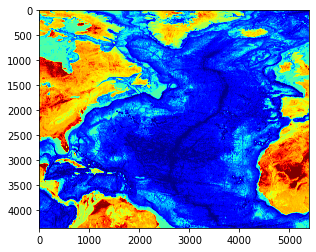

In [484]:
sge=segmentation(Map(r[0][0]))
plt.imshow(sge,cmap='jet')

In [ ]:
seg=merge(run_on(lambda dta: segmentation(Map(dta)),r))
plt.imshow(seg,cmap='jet')

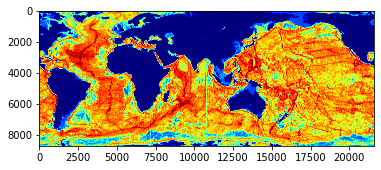

In [489]:
plt.imshow((16-seg)*(seg<=15),cmap='jet')

In [4]:
def cut(ta):
    aa=ta[0]
    bb=ta[1]
    for a in range(len(aa)):
        ta[0][a]=ta[0][a][1050:]
    for b in range(len(bb)):
        ta[1][b]=ta[1][b][:-1050]
    return ta

In [5]:
def run_on(f,tab):
    trslt=[]
    for a in tab:
        rs=[]
        for b in a:
            rs.append(f(b))
        trslt.append(rs)
    return trslt
def run_on_d1(f,tab):
    trslt=[]
    for b in tab:
        trslt.append(f(b))
    return trslt
def merge(tab):
    ah=np.hstack(tab[0])
    ab=np.hstack(tab[1])
    fin=np.vstack((ah,ab))
    return fin
def access(tab,k):
    m=len(tab[0])
    return [[tab[0][i][k] for i in range(m)],
                     [tab[1][i][k] for i in range(m)]]
def merges(tab):
    tabs=[]
    for k in range(len(tab[0][0])):
        tabs.append(merge(access(tab,k)))
    return tabs
        

In [6]:
start=[['data_plus_grande.tif','eurasie.tif','est.tif','far east.tif'],
       ['westdown.tif','eurasie_down.tif','est_down.tif','fareast_down.tif']]

In [7]:
r=run_on(load_data,start)
r=cut(r)

In [8]:
rr=merge(r)

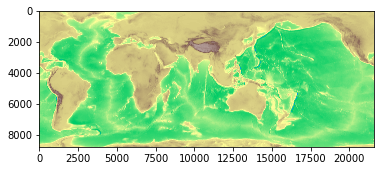

In [485]:
plt.imshow(rr,cmap='terrain')
plt.show()

In [ ]:
inds=run_on(lambda dta: indicators(Map(dta)),r)
a_inds=merges(inds)

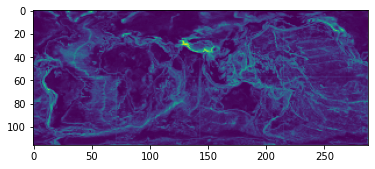

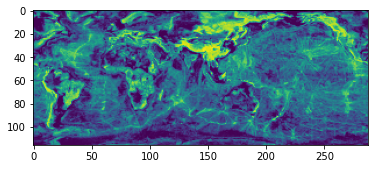

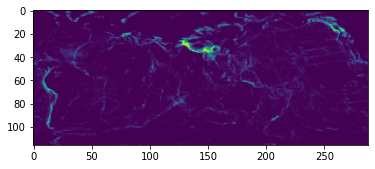

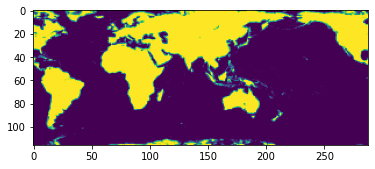

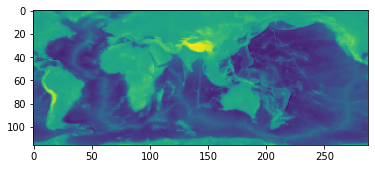

In [350]:
for k in a_inds:
    plt.figure()
    plt.imshow(k)
    plt.show()

In [9]:
def stat_normal(x):
    return (x-x.mean())/(x.std())

In [351]:
na_inds=run_on_d1(stat_normal,a_inds)

In [417]:
na_inds[0].shape

(88, 216)

In [352]:

data=[]
labels=[]
n,m=na_inds[0].shape[0],na_inds[0].shape[1]
for i in range(n):
    for j in range(m):
        if True:#a_inds[-2][i,j]<1:
            a=[gr[i,j] for gr in na_inds]
            data.append(a)
            labels.append((i,j))


In [12]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [13]:
inertias=[]
ints=[]
ll=[]
distortions=[]
data=np.array(data)
for l in range(2,24):
    ll.append(l)
    model = KMeans(l)
    model.fit(data, y=None, sample_weight= None)
    score = silhouette_score(data, model.labels_)
    ints.append(model.inertia_)
    inertias.append(score)

KeyboardInterrupt: 

In [425]:
inertias=np.array(inertias)
ints=np.array(ints)

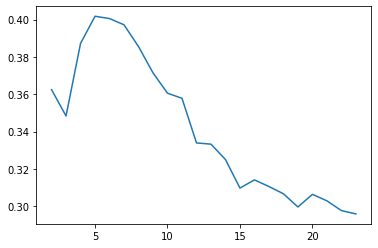

In [426]:

plt.plot(ll,inertias)

In [349]:
data=np.array(data)

In [350]:
data.shape

(76032, 4)

In [252]:

model = KMeans(n_clusters=7)
model.fit(data, y=None, sample_weight= None)
#rslt2=clust.map_clusters(model.labels_,labels,the_map.data.shape,(54,54))

KMeans(n_clusters=7)

In [253]:

rslt = np.zeros((na_inds[0].shape[0],na_inds[0].shape[1]))
for k in range(len(model.labels_)):
    x,y = labels[k]
    rslt[x,y] = model.labels_[k]


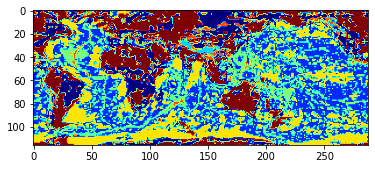

In [259]:
plt.imshow(rslt,cmap='jet')
plt.show()

In [4]:
import matplotlib

In [10]:
for i in range(0,int(np.max(seg))+1):
    plt.figure()
    plt.title(f"{i}: {(seg==i).mean() * 100} %")
    a=np.zeros(seg.shape)
    a[seg==i]=np.NaN
    a[0,0]=0
    a[0,1]=0
    b=rr
    b[0,0]=np.max(b)
    b[1,0]=np.min(b)
    b+=a
    cma=matplotlib.cm.terrain
    cma.set_bad('black')
    plt.imshow(b,cmap=cma)

NameError: name 'seg' is not defined

In [62]:
selection=na[100*i:100*(i+1),100*j:100*(j+1)]
plt.imsave(f'img{i}{j} mean={np.mean(selection)} minmax={np.max(selection)-np.min(selection)}.png',selection,cmap='Spectral')

In [ ]:
for k in range(20):
    i=np.random.choice(list(range(100)))
    j=np.random.choice(list(range(100)))
    plt.figure()
    selection=na[100*i:100*(i+1),100*j:100*(j+1)]
    plt.imshow(selection,cmap='Spectral')
    plt.colorbar()
    plt.title(np.mean(selection))
    c=np.zeros((100,100))
    plt.figure()
    c[i,j]=np.nan
    cma=matplotlib.cm.terrain
    cma.set_bad('black')
    plt.imshow(transform(reduction)+c,cmap=cma)

In [197]:
plt.imsave('truc.png',oeuvre2,cmap='gray')

In [121]:
np.min(dta),np.max(dta)

(-455.125, 1690.25)

In [122]:
np.min(dta)/(np.max(dta)-np.min(dta))

-0.21214239934743342

In [49]:
normeGradient2=normeGradient.copy()
for i in range(20):
    normeGradient2=normeGradient2+0.1*laplacien(normeGradient2)

In [39]:
data,labels=the_map.get_indicators_data(indicators=clust.base_indicators,reduce=clust.reduce)

In [135]:
from sklearn.cluster import KMeans, MiniBatchKMeans

red_mean,red_grad,red_minmax,red_terre_mer

In [198]:
the_map=m.Map(na)

In [136]:
a=the_map.get_indicators_data(clust.base_indicators,(54,54))

a


In [9]:
import numpy as np

In [278]:
import importlib
importlib.reload(clust)

<module 'OceanPSC.clustering' from 'C:\\Users\\nicol\\source\\repos\\OceanPSC\\OceanPSC\\clustering.py'>

In [9]:
filt=np.array([1,1,1])
truc=clust.clusters(the_map,filt,nb_cluster=6)

In [8]:
import OceanPSC.clustering as clust

In [105]:
dta

array([[0.37089096, 0.17990304, 0.70878156, 0.52046533],
       [0.36925216, 0.16116678, 0.71371612, 0.51975243],
       [0.36691265, 0.16035704, 0.72257434, 0.5182924 ],
       ...,
       [0.19577512, 0.14709082, 0.45553931, 0.53262546],
       [0.20164875, 0.14724444, 0.45712232, 0.53629264],
       [0.20805407, 0.2787798 , 0.45156724, 0.53683357]])

In [355]:
data.shape

(33408, 5)

In [354]:
data=np.array(data)

In [621]:
76032**2

5780865024

In [30]:
len(['in_grad','itexture','iconv','dpi_ind','terre_mer','alt'])

6

In [356]:
filt=np.array([1,1,1,0,1])
filt=filt.size*(filt/filt.sum())

In [357]:
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist


#calculate distance matrix
distance_matrix = pdist(data*filt)
#apply hierarchical clustering
clusters = linkage(distance_matrix, 'ward')

In [304]:
np.save('clusters',clusters)

In [369]:
rslt1=fcluster(clusters, 35,criterion='distance')
print(np.max(rslt1))

rslt = np.zeros(a_inds[0].shape)
for k in range(len(rslt1)):
    x,y = labels[k]
    rslt[x,y] = rslt1[k]

rslt=rslt-1
nc=int(np.max(rslt))

20


In [11]:
def nested_means_segment(slop,texture,conv,filtre=None):
    categs=-np.ones(slop.shape)

    #slope, slop_mean, slop_la_mean, slop_lq_mean
    def cut_offs(slop):
        slop_mean=slop.mean()
        slop_la=slop[slop<=np.median(slop)]
        slop_la_mean=slop_la.mean()
        slop_lq_mean=slop_la[slop_la<=np.median(slop_la)].mean()
        return slop_mean,slop_la_mean,slop_lq_mean
    
    if filtre is None:
        slop_mean,slop_la_mean,slop_lq_mean=cut_offs(slop)
        conv_mean, conv_la_mean, conv_lq_mean=cut_offs(conv)
        texture_mean, texture_la_mean, texture_lq_mean=cut_offs(texture)
    else:
        slop_mean,slop_la_mean,slop_lq_mean=cut_offs(slop[filtre])
        conv_mean, conv_la_mean, conv_lq_mean=cut_offs(conv[filtre])
        texture_mean, texture_la_mean, texture_lq_mean=cut_offs(texture[filtre])
        
        
    def questions(slop_cut,conv_cut,texture_cut):
        quest1=(slop>=slop_cut)
        quest2=(conv>=conv_cut)
        quest3=(texture>=texture_cut)
        return quest1,quest2,quest3
    
    quest1,quest2,quest3=questions(slop_mean,conv_mean,texture_mean)
    quest4,quest5,quest6=questions(slop_la_mean,conv_la_mean,texture_la_mean)
    quest7,quest8,quest9=questions(slop_lq_mean,conv_lq_mean,texture_lq_mean)
    

    sq11=quest1&quest2
    sq12=quest1&(~quest2)

    categs[sq11&quest3]=0
    categs[sq11&(~quest3)]=1
    categs[sq12&quest3]=2
    categs[sq12&(~quest3)]=3

    sq2=(~quest1)&quest4
    sq21=sq2&quest5
    sq22=sq2&(~quest5)

    categs[sq21&quest6]=4
    categs[sq21&(~quest6)]=5
    categs[sq22&quest6]=6
    categs[sq22&(~quest6)]=7

    sq3=(~quest1)&(~quest4)&quest7
    sq31=sq3&quest8
    sq32=sq3&(~quest8)

    categs[sq31&quest9]=8
    categs[sq31&(~quest9)]=9
    categs[sq32&quest9]=10
    categs[sq32&(~quest9)]=11

    sq4=(~quest1)&(~quest4)&(~quest7)
    sq41=sq4&quest8
    sq42=sq4&(~quest8)

    categs[sq41&quest9]=12
    categs[sq41&(~quest9)]=13
    categs[sq42&quest9]=14
    categs[sq42&(~quest9)]=15
    
    categs[~filtre]=-1
    return categs

In [472]:
slop=a_inds[0]
texture=a_inds[1]
conv=a_inds[2]
rslt=nested_means_segment(slop,texture,conv)

In [461]:
vois=op.neighbor_grid(rslt,bound_method="duplicate")
tt=0
ta=0
for k in range(nc+1):
    definer=(vois==k)
    refiner=(definer.sum(axis=-2)==3).sum(axis=-1)>0
    refiner_v=(definer.sum(axis=-1)==3).sum(axis=-1)>0
    sc_refiner=(definer.sum(axis=-2)>=2).sum(axis=-1)>0
    sc_refiner_v=(definer.sum(axis=-1)>=2).sum(axis=-1)>0
    decider=(refiner & refiner_v) | (refiner & sc_refiner_v) | (refiner_v & sc_refiner)
    cts=definer.sum(axis=(-1,2))
    coef=(vois*(vois!=k)).std(axis=(-1,-2))
    ta+=((coef==0) & (cts==5)).sum()
    sup_selector=(cts>5)|(cts==5 & (coef!=0))
    decider=decider & sup_selector
    tt+=(rslt[decider]!=k).sum()
    rslt[decider]=k
print(tt,ta)

433 209


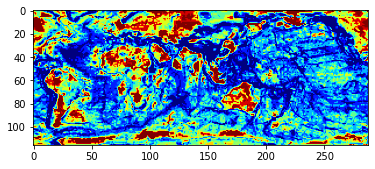

In [473]:
plt.imshow(rslt,cmap='jet')

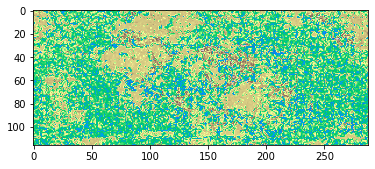

In [457]:
plt.imshow(recreate_direct2(rslt,rslt,a_inds[-1]),cmap='terrain')

In [400]:
categ

21

In [390]:
2*len(),slop.size

(33408, 33408)

In [391]:
33408/2

16704.0

In [276]:
coef.shape

(116, 288)

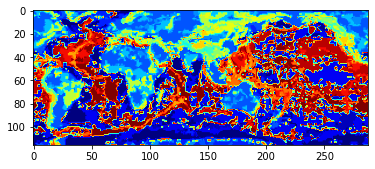

In [384]:
plt.imshow(rslt,cmap='jet')

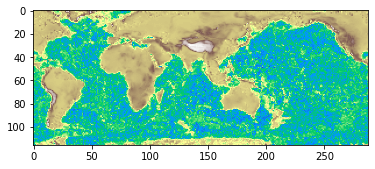

In [378]:
rs=recreate_direct2(rslt,rslt,a_inds[-1])
rs[a_inds[-2]==1]=a_inds[-1][a_inds[-2]==1]
plt.imshow(rs,cmap='terrain')

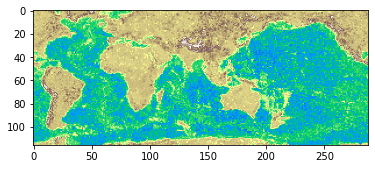

In [327]:

plt.imshow(recreate_direct2(rslt,rslt,a_inds[-1]),cmap='terrain')

In [25]:
import OceanPSC.perlin as p

In [426]:
def recreate_direct(creation,rslt,base):
    clust_values=[]
    nc=int(np.max(rslt))
    new_c=np.zeros(creation.shape)
    for k in range(nc+1):
        tirage=np.random.choice(base[rslt==k],size=new_c.shape)
        new_c[creation==k]=tirage[creation==k]
    return new_c

In [655]:
a=np.ones(a_inds[-1].shape)
a[a_inds[-1]>=0]=np.nan

In [427]:
def recreate_direct2(creation,rslt,base):
    nc=int(np.max(rslt))
    def create_carte():
        alpha = 1 / 2
        omega = 2
        i = np.arange(base.shape[1])
        j = np.arange(base.shape[0])
        I,J = np.meshgrid(i,j)
        carte = p.perlin(J / 50,I / 50,alpha,omega,20)
        carte=carte-np.mean(carte)
        carte=carte/np.std(carte)
        carte=carte-np.min(carte)
        carte=carte/(np.max(carte)+1)
        return carte
    base_carte=create_carte()
    new_c=np.zeros(creation.shape)
    for k in range(nc+1):
        carte=np.int32(base_carte*base[rslt==k].size)
        tirage=base[rslt==k][carte]
        #tirage=np.random.choice(tirage[rslt==k],size=new_c.shape)
        new_c[creation==k]=tirage[creation==k]
    return new_c

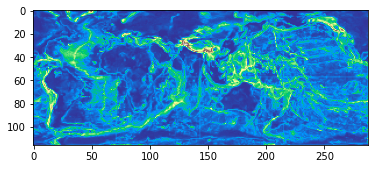

In [823]:
plt.imshow(a_inds[0],cmap='terrain')

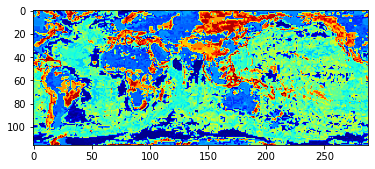

In [833]:
plt.imshow(rslt,cmap='jet')
plt.show()

In [449]:
import matplotlib
import copy

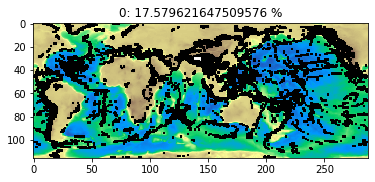

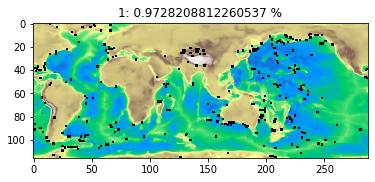

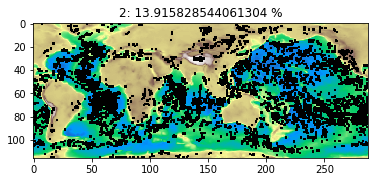

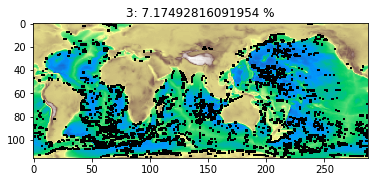

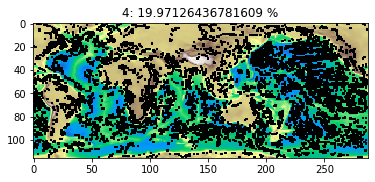

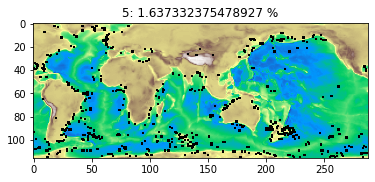

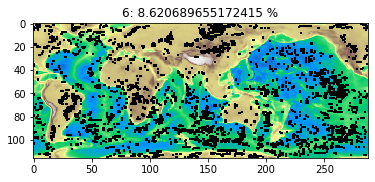

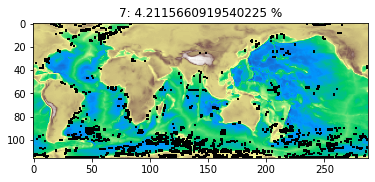

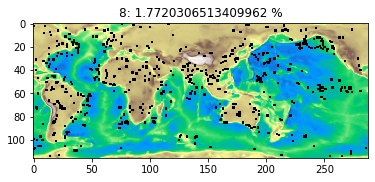

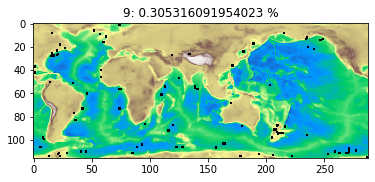

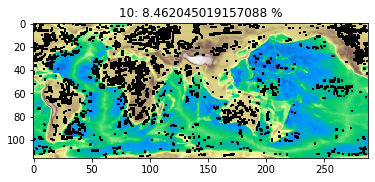

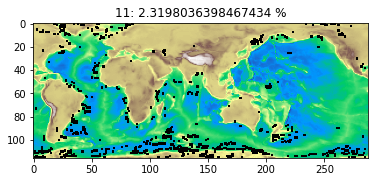

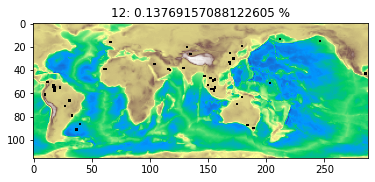

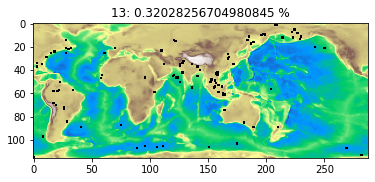

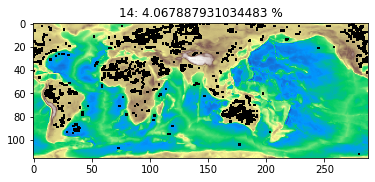

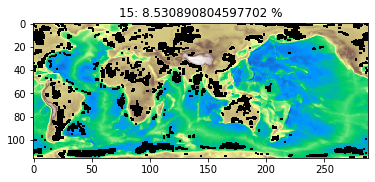

In [450]:
for i in range(0,int(np.max(rslt))+1):
    plt.figure()
    plt.title(f"{i}: {(rslt==i).mean() * 100} %")
    a=np.zeros(a_inds[-1].shape)
    a[rslt==i]=np.NaN
    a[0,0]=0
    a[0,1]=0
    b=a_inds[-1]
    b[0,0]=1
    b[1,0]=0
    
    cma=copy.copy(matplotlib.cm.get_cmap("terrain"))
    cma.set_bad('black')
    plt.imshow(a+b,cmap=cma)
    plt.show()

In [328]:

nc=int(np.max(rslt))
mapping_graph=np.zeros((nc+1,nc+1))
vois=op.neighbor_grid(rslt)
filt=np.ones((3,3))
filt[1,1]=np.nan

In [286]:
np.min(vois)

0.0

In [267]:
vois[rslt==1].shape

(9339, 3, 3)

In [329]:
for k in range(nc+1):
    vois_tr=vois[rslt==k]*filt
    vois_tr=vois_tr.reshape(-1)
    for j in range(nc+1):
        mapping_graph[k,j]=np.mean(vois_tr==j)
mapping_graph=mapping_graph/np.sum(mapping_graph,axis=-1)

In [347]:
np.sum(mapping_graph[6])

53408.0

In [343]:
mapping_graph.shape

(7, 7)

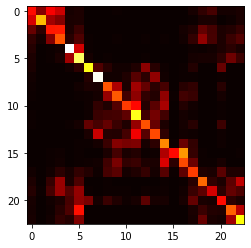

In [330]:
plt.imshow(mapping_graph,cmap='hot')

In [331]:
pd.DataFrame(mapping_graph)

0         1         2         3         4         5         6   \
0   0.253521  0.124120  0.237676  0.194542  0.014085  0.019366  0.000000   
1   0.202586  0.428161  0.152299  0.120690  0.015805  0.018678  0.000000   
2   0.091321  0.034326  0.266192  0.269754  0.018782  0.048251  0.002267   
3   0.037529  0.012125  0.120237  0.324480  0.029590  0.069428  0.003320   
4   0.026415  0.000496  0.002614  0.009241  0.664263  0.198116  0.003922   
5   0.018384  0.000444  0.005092  0.016437  0.150185  0.558092  0.010627   
6   0.016143  0.000000  0.000785  0.002578  0.009753  0.034865  0.509641   
7   0.009533  0.000000  0.000000  0.000000  0.000047  0.000698  0.028320   
8   0.005941  0.000000  0.000000  0.000871  0.002456  0.008159  0.020516   
9   0.004938  0.000000  0.000203  0.001488  0.001082  0.003111  0.005952   
10  0.001609  0.000000  0.000000  0.000984  0.000268  0.001431  0.006527   
11  0.002865  0.000000  0.000000  0.000269  0.000119  0.000806  0.005968   
12  0.004027  0.000000  0.000158  0.001579  0.002685  0.011766  0.089940   
13  0.001182  0.000000  0.000000  0.000000  0.000460  0.001117  0.017275   
14  0.001502  0.000000  0.000313  0.001815  0.000876  0.002879  0.002942   
15  0.000000  0.000000  0.003012  0.007530  0.000000  0.003012  0.000000   
16  0.001906  0.000136  0.004493  0.009668  0.001089  0.003949  0.005447   
17  0.009643  0.000238  0.007857  0.033214  0.014524  0.040357  0.025000   
18  0.019254  0.001681  0.042023  0.141656  0.017115  0.066320  0.001528   
19  0.026596  0.003989  0.058843  0.142620  0.073803  0.134973  0.003657   
20  0.015476  0.000132  0.007804  0.018783  0.059788  0.132937  0.110185   
21  0.012040  0.000443  0.007082  0.029922  0.064890  0.259207  0.001151   
22  0.014969  0.000862  0.010110  0.039263  0.027194  0.116223  0.000549   

          7         8         9   ...        13        14        15        16  \
0   0.000880  0.000000  0.003521  ...  0.000000  0.000000  0.000000  0.001761   
1   0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.001437   
2   0.000000  0.000000  0.000972  ...  0.000000  0.001619  0.000648  0.010687   
3   0.000000  0.001588  0.003176  ...  0.000000  0.004186  0.000722  0.010248   
4   0.000045  0.001397  0.000721  ...  0.000316  0.000631  0.000000  0.000361   
5   0.000513  0.003520  0.001572  ...  0.000581  0.001572  0.000068  0.000991   
6   0.068274  0.029036  0.009865  ...  0.029484  0.005269  0.000000  0.004484   
7   0.655041  0.009952  0.008231  ...  0.134301  0.009254  0.000000  0.003162   
8   0.016952  0.324620  0.162151  ...  0.032478  0.061787  0.000951  0.030418   
9   0.011972  0.138460  0.330357  ...  0.025636  0.133320  0.002638  0.055398   
10  0.040325  0.022264  0.073856  ...  0.079757  0.156116  0.000984  0.025751   
11  0.049206  0.056189  0.057353  ...  0.103814  0.054697  0.000477  0.010653   
12  0.061513  0.088992  0.047931  ...  0.092072  0.019267  0.000237  0.010976   
13  0.189700  0.026931  0.024895  ...  0.314109  0.036653  0.000263  0.008539   
14  0.012456  0.048823  0.123373  ...  0.034927  0.378568  0.006823  0.094392   
15  0.000000  0.018072  0.058735  ...  0.006024  0.164157  0.250000  0.393072   
16  0.009259  0.052288  0.111520  ...  0.017702  0.205338  0.035539  0.315359   
17  0.006667  0.062262  0.077857  ...  0.012381  0.076548  0.003333  0.083095   
18  0.000000  0.003209  0.000764  ...  0.000153  0.003209  0.000458  0.004890   
19  0.000665  0.002992  0.004654  ...  0.003989  0.005652  0.000000  0.010306   
20  0.012831  0.048413  0.022354  ...  0.014815  0.015344  0.000132  0.013492   
21  0.000531  0.001505  0.001328  ...  0.000089  0.000974  0.000000  0.000620   
22  0.000157  0.000392  0.000627  ...  0.000078  0.000549  0.000157  0.000627   

          17        18        19        20        21        22  
0   0.013204  0.036972  0.059859  0.010563  0.012324  0.017606  
1   0.002874  0.015805  0.017241  0.001437  0.007184  0.015805  
2   0.021373  0.089054  0.057319  0.019106  0

In [332]:
def neighbours(x,y):
    tab=[(x+1,y),(x-1,y),(x,y+1),(x,y-1),(x+1,y+1),(x-1,y-1),(x+1,y-1),(x-1,y+1)]
    N,M=rslt.shape
    tbr=[]
    for i,j in tab:
        if 0<=i<N and 0<=j<M:
            tbr.append((i,j))
    np.random.shuffle(tbr)
    return tbr

In [333]:
cats=[i for i in range(nc+1)]

In [334]:
creation=-np.ones(rslt.shape)
creation[a_inds[-1]>=0]=rslt[a_inds[-1]>=0]
while (creation==-1).sum() != 0:
    vois=op.neighbor_grid(creation)
    vals=((vois!=-1).sum(axis=(-1,-2)))*(creation==-1)
    index=np.random.randint(0,(vals==vals.max()).sum())
    mat=np.int32(vois[vals==vals.max()][index])
    ps=mapping_graph[mat].mean(axis=(0,1))
    for ii in lcu:
        ps[int(ii)]=0
    ps=ps/ps.sum()
    categ=np.random.choice(cats,p=ps)
    emptyness=-np.ones(((vals==vals.max()).sum()))
    emptyness[index]=categ
    creation[vals==vals.max()]=emptyness
    if (creation==-1).sum()%1000==0:
        print((creation==-1).sum())

NameError: name 'lcu' is not defined

In [343]:
landclusters=rslt[a_inds[-1]>=0]

In [344]:
lcu=[]
for l in np.unique(landclusters):
    if (((rslt==l)*(a_inds[-1]>=0)).mean()/(rslt==l).mean()) > 0.9:
        lcu.append(l)

In [985]:
creation[vals==vals.max()]=1

In [ ]:
cre

In [965]:
mat.shape

(3, 3)

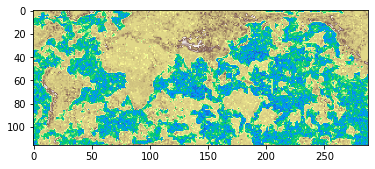

In [346]:
plt.imshow(recreate_direct2(creation,rslt,a_inds[-1]),cmap="terrain")

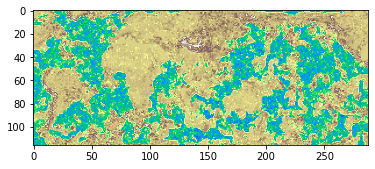

In [342]:
plt.imshow(recreate_direct2(creation,rslt,a_inds[-1]),cmap="terrain")

In [345]:
creation=-np.ones(rslt.shape)
creation[a_inds[-1]>=0]=rslt[a_inds[-1]>=0]
stack=[(20,30)]
creation[20,30]=rslt[20,50]
while len(stack)!=0:
    topx,topy=stack.pop()
    for cx,cy in neighbours(topx,topy):
        if creation[cx,cy]!=-1:
            continue
        stack.append((cx,cy))
        ps=mapping_graph[int(creation[topx,topy])]
        for ii in lcu:
            ps[int(ii)]=0
        ps=ps/ps.sum()
        categ=np.random.choice(cats,p=ps)
        creation[cx,cy]=categ

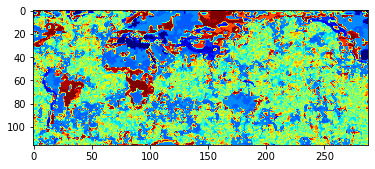

In [347]:
plt.imshow(creation,cmap="jet")

In [529]:
nc

41

(array([ 2.,  0.,  8.,  6.,  4., 12.,  3.,  6.,  6.,  3.]),
 array([ 358.99506667,  579.74836222,  800.50165778, 1021.25495333,
        1242.00824889, 1462.76154444, 1683.51484   , 1904.26813556,
        2125.02143111, 2345.77472667, 2566.52802222]),
 <BarContainer object of 10 artists>)

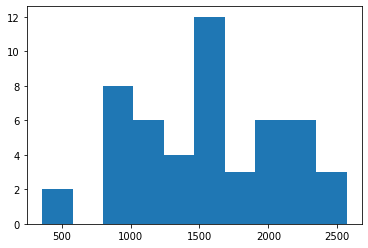

In [562]:
plt.hist(alt[rslt==1])

In [563]:
def recreate(creation):
    clust_values=[]
    im_locs=np.zeros(rslt.shape)
    im_sizes=np.zeros(rslt.shape)
    alt=a_inds[-1]
    for k in range(nc+1):
        moy=np.mean(alt[rslt==k])
        std=np.std(alt[rslt==k])
        im_locs[creation==k]=moy
        im_sizes[creation==k]=std
        print(moy,std)
    return im_locs,im_sizes

In [567]:
np.random.choice?

In [564]:
im_locs,im_sizes,clust_values=recreate(creation)
clust_values

3891.058023737374 786.3062328946694
1556.8304084444444 524.0829771684901
4443.346053418803 592.1176979531124
1160.985641161616 578.3897342342351
4156.5543 529.0632237415372
2270.61333625731 1047.5693053409168
3738.0075145299143 594.4275887141443
3020.6706684444443 1329.8315736492502
1580.5415068100358 581.9439921290946
1153.3454794871798 430.9721227599898
1464.1756894179894 599.4834426057029
1337.6515857881138 857.5224824228676
956.5467027777779 335.8123829099923
1263.4278036429873 572.7323206119513
1626.5689255892253 966.5534697466292
876.1078597883597 368.14232378982246
3166.7856074074075 1082.479546598518
895.850217495854 444.60449613913727
355.29436425120775 602.2104898569825
1001.0763544871794 552.5497687792443
410.2145384742951 544.7282047961743
1121.8832578544059 526.9199320161088
594.5886191919192 448.3974060841469
4354.757219753086 550.0485502787842
3989.944304814815 774.2532179280404
1096.6372978243976 552.1480812235804
1542.082889569161 468.48063513314435
44.412551068376075 

ValueError: not enough values to unpack (expected 3, got 2)

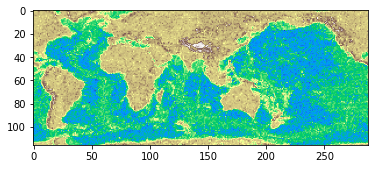

In [577]:
plt.imshow(recreate_direct(rslt),cmap='terrain')

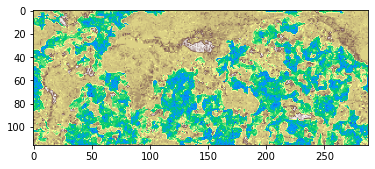

In [571]:
plt.imshow(recreate_direct(creation),cmap='terrain')

In [544]:
im_rs=np.random.normal(im_locs,im_sizes)

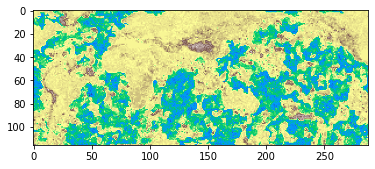

In [557]:
plt.imshow(im_rs,cmap='terrain')

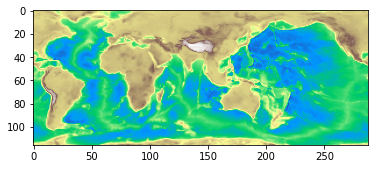

In [484]:
plt.imshow(alt,cmap='terrain')

In [426]:
alt[0,0]=np.min(im_rs)

C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("terrain"))
  del sys.path[0]


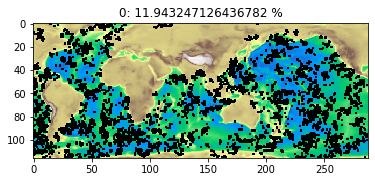

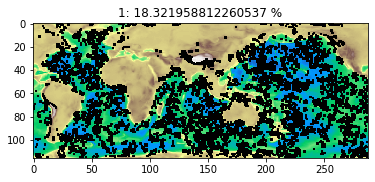

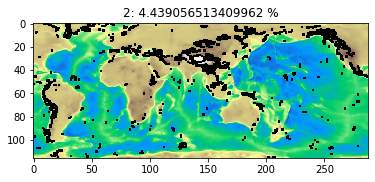

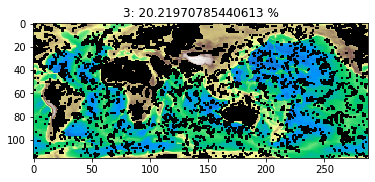

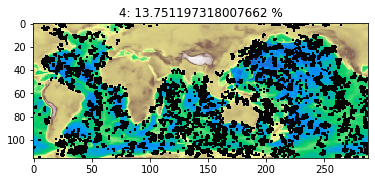

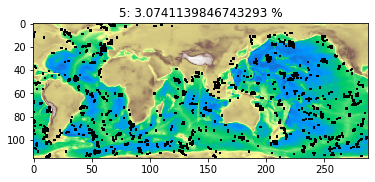

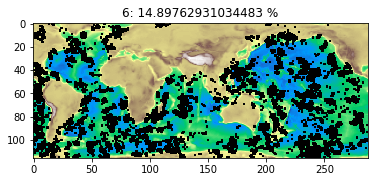

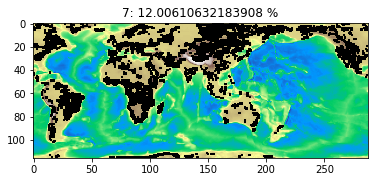

In [397]:
for i in range(0,int(np.max(creation))+1):
    plt.figure()
    plt.title(f"{i}: {(creation==i).mean() * 100} %")
    a=np.zeros(a_inds[-1].shape)
    a[creation==i]=np.NaN
    a[0,0]=0
    a[0,1]=0
    b=a_inds[-1]
    b[0,0]=1
    b[1,0]=0
    
    cma=matplotlib.cm.terrain
    cma.set_bad('black')
    plt.imshow(a+b,cmap=cma)
    plt.show()

In [376]:
np.unique(creation)

array([0., 1., 2., 3., 4., 5., 6.])

In [323]:
st=[1,2,3]

In [324]:
st.pop()

3

In [271]:
filt

array([[1., 1., 1.],
       [1., 0., 1.],
       [1., 1., 1.]])

In [ ]:
np

In [ ]:

k=dendrogram(clusters,    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  orientation='top')

KeyboardInterrupt: 

In [127]:
rslt2 = np.zeros((100,100))
for k in range(len(rslt)):
    x,y = lab[k]
    rslt2[x,y] = rslt[k]


In [18]:
from sklearn.cluster import DBSCAN

In [15]:
R=1/100

In [118]:
def n_s_point(eps,min_samples):
    model = DBSCAN(eps=eps,min_samples=min_samples)
    model.fit(ent)
    ml=np.array(model.labels_)
    mi=np.min(ml)
    return (ml!=mi).mean(),np.max(ml)-mi

In [158]:
n_s_point(R*5,8)

(0.9799, 8)

In [161]:
model = DBSCAN(eps=R*5,min_samples=8)
model.fit(ent)
ml=np.array(model.labels_)

In [141]:
x=np.linspace(1,20,25)
aa=[]
bb=[]
for k in x:
    a,b=n_s_point(k*R,10)
    aa+=[a]
    bb+=[b]


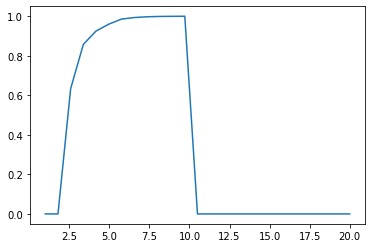

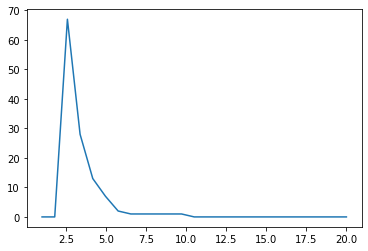

In [142]:
plt.plot(x,aa)
plt.figure()
plt.plot(x,bb)

In [143]:
import pandas as pd

In [149]:
galaxy=pd.DataFrame(ent,columns=['x','y','z'])

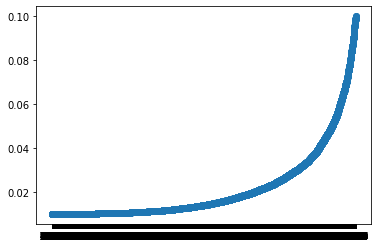

In [153]:
df2=pd.DataFrame(columns=['index','distance'])
for i in range(0,len(galaxy)-1):
    dist=np.linalg.norm(galaxy.iloc[i]-galaxy.iloc[i+1])
    df2=df2.append({'index': str(i),'distance':dist}, ignore_index=True)

df2=df2.sort_values(by=['distance'])
df2=df2[df2['distance']<0.1]
plt.scatter(df2['index'],df2['distance'])
plt.show()

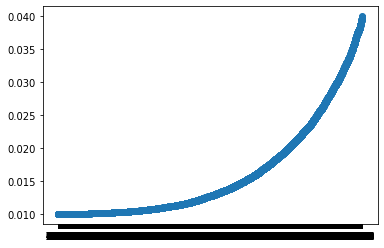

In [178]:
df3=df2[df2['distance']<0.04]
df3=df3.sort_values(by=['distance'])
plt.scatter(df3['index'],df3['distance'])
plt.show()

In [249]:
ent

array([[    0.        ,     0.        , -3404.64810528],
       [    0.        ,   216.        , -3420.39311128],
       [    0.        ,   432.        , -3442.87024177],
       ...,
       [21384.        , 20952.        , -5087.09942987],
       [21384.        , 21168.        , -5030.66758831],
       [21384.        , 21384.        , -4969.12759345]])

In [230]:
for n in range(2,10):
    rslts=[]
    for k in range(1,20):
        eps=0.01+(k/20)*0.01*(2**(1/2)-1)
        rslts.append(n_s_point(eps,n))
    rslts=np.array(rslts)
    print(np.var(rslts),n)

5138.243767313018 2
3191.0858725761777 3
2331.811634349031 4
701.2908587257616 5
0.0 6
0.0 7
0.0 8
0.0 9


In [268]:
ent

array([[ 0.00000000e+00,  0.00000000e+00, -3.40464811e+03],
       [ 0.00000000e+00,  9.72000000e+04, -3.42039311e+03],
       [ 0.00000000e+00,  1.94400000e+05, -3.44287024e+03],
       ...,
       [ 9.62280000e+06,  9.42840000e+06, -5.08709943e+03],
       [ 9.62280000e+06,  9.52560000e+06, -5.03066759e+03],
       [ 9.62280000e+06,  9.62280000e+06, -4.96912759e+03]])

In [ ]:
model = DBSCAN(eps=R*1.00001,min_samples=2)
model.fit(ent)

In [ ]:
np.max(model.labels_)

In [169]:
(model.labels_==2).mean()

0.0009

In [192]:
model = DBSCAN(eps=R*2,min_samples=7)
model.fit(ent)
ml=np.array(model.labels_)

In [193]:
rslt2 = np.zeros((100,100))
for k in range(len(model.labels_)):
    x,y = int(galaxy.x[k]*100),int(galaxy.y[k]*100)
    rslt2[x,y] = model.labels_[k]


In [120]:
dta[1]

array([0.36925216, 0.16116678, 0.71371612, 0.51975243])

In [122]:
dta[1]+lab[1]

ValueError: operands could not be broadcast together with shapes (4,) (2,) 

In [129]:
dt2=[]
for a in range(len(dta)):
    dt2.append(list(dta[a][:-3])+list(lab[a]/100))

In [329]:
distance_matrix.mean()

0.35368397408929303

In [24]:
distance_matrix.shape

(49995000,)

In [28]:
distance_matrix2=pdist(lab)

In [36]:
distance_matrix=distance_matrix+0.3*(distance_matrix2>3)

In [37]:

clusters = linkage(distance_matrix, 'ward')

In [27]:
pdist?

In [26]:
np.array(dta).shape

(10000, 4)

In [164]:
np.array(dta).shape

(10000, 6)

In [12]:
gr=the_map.indicator_grid(np.mean,normaliser=True)

In [237]:
gr

array([[-3404.64810528, -3420.39311128, -3442.87024177, ...,
        -4221.42616169, -4219.39188957, -4217.79413152],
       [-1967.52477709, -1955.70188186, -1928.69084362, ...,
        -4319.80506259, -4320.44500171, -4323.45198903],
       [-1933.46054098, -1940.46778549, -1956.2184285 , ...,
        -4333.13944616, -4334.07317387, -4337.08200446],
       ...,
       [-2014.71787123, -2370.81927298, -2545.58054698, ...,
        -5096.83611968, -5082.39666924, -4937.27149777],
       [-2224.73679698, -2461.58189729, -2609.64714078, ...,
        -5109.43447788, -5061.84645062, -4969.27190501],
       [-2014.0267704 , -2315.73493227, -2545.84728652, ...,
        -5087.09942987, -5030.66758831, -4969.12759345]])

In [56]:
n,m=gr.shape
ent=[]
for i in range(n):
    for j in range(m):
        ent.append([i/100,j/100,gr[i,j]])
ent=np.array(ent)

In [37]:
np.array(np.gradient(gr)).shape

(2, 100, 100)

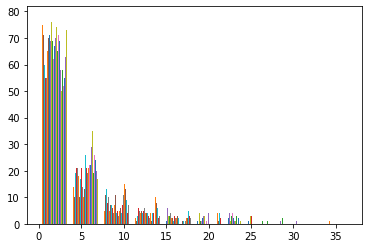

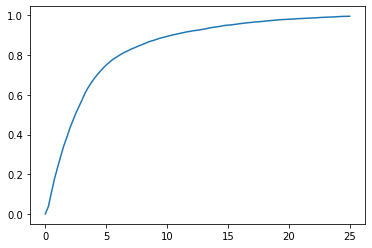

In [90]:
X,Y=np.array(np.gradient(gr))*100
k=plt.hist(np.sqrt(X**2+Y**2))

xx=np.linspace(0,25,100)
rsl=[]
for a in xx:
    rsl.append((np.sqrt(X**2+Y**2)<=a).mean())
    
plt.figure()
plt.plot(xx,rsl)

In [92]:
rsl=np.array(rsl)

In [94]:
xx[rsl>=0.9].min()

10.606060606060607

In [54]:
rslt=fcluster(clusters, 6, depth=7)
np.max(rslt)

11

1

In [63]:
fcluster?

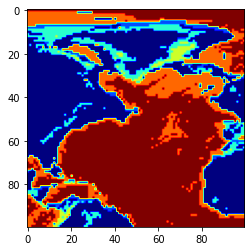

In [321]:
plt.imshow(rslt2*(1-k),cmap='jet')

In [14]:
!pip install scipy==1.7.1

  Cache entry deserialization failed, entry ignored
  Could not find a version that satisfies the requirement scipy==1.7.1 (from versions: 0.8.0, 0.9.0, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.12.1, 0.13.0, 0.13.1, 0.13.2, 0.13.3, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.16.0, 0.16.1, 0.17.0, 0.17.1, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 1.0.0, 1.0.1, 1.1.0, 1.2.0, 1.2.1, 1.2.2, 1.2.3, 1.3.0, 1.3.1, 1.3.2, 1.3.3, 1.4.0, 1.4.1, 1.5.0, 1.5.1, 1.5.2, 1.5.3, 1.5.4)
No matching distribution found for scipy==1.7.1
You are using pip version 9.0.1, however version 22.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [12]:
for i in range(1,int(np.max(rslt2))+1):
    a,b=((rslt2==i) & (k==1)).mean(),((rslt2==i) & (k==0)).mean()
    if a==0.0 or b==0.0:
        print('yes')
    else:
        print(min(a/(a+b),b/(a+b)))

NameError: name 'rslt2' is not defined

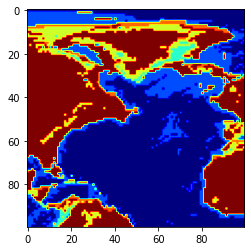

In [325]:
plt.imshow(rslt2,cmap='jet')

In [300]:
k=(the_map.indicator_grid(np.mean,normaliser=False)>=0)

In [295]:
g=the_map.indicator_grid(np.mean)

In [202]:
np.array(dta).shape

(10000, 3)

In [20]:
clusters.shape

(9999, 4)

In [9]:

k=dendrogram(clusters,    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  orientation='top')

NameError: name 'dendrogram' is not defined

In [8]:
plt.figure()

<Figure size 432x288 with 0 Axes>

In [21]:
plt.show()

KeyboardInterrupt: 

In [22]:
%matplotlib qt4

C:\Users\nicol\Anaconda3\lib\importlib\__init__.py:126: MatplotlibDeprecationWarning: 
The matplotlib.backends.backend_qt4agg backend was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  return _bootstrap._gcd_import(name[level:], package, level)


In [331]:
!conda install ipykernel=6.2.0

Fetching package metadata ...........



PackageNotFoundError: Package missing in current win-64 channels: 
  - ipykernel 6.2.0*



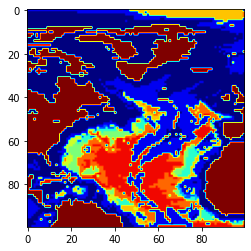

In [223]:
plt.imshow(-rslt2,cmap='jet')

In [ ]:

    print(the_map.indicator_grid(np.mean)[rslt2==i].mean(),the_map.indicator_grid(np.mean,lambda m: m.norme_grad)[rslt2==i].mean(),

In [207]:
linkage?

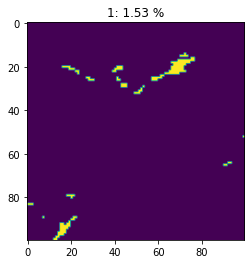

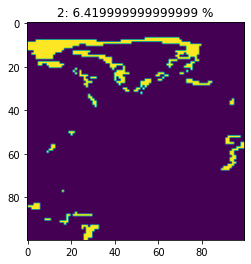

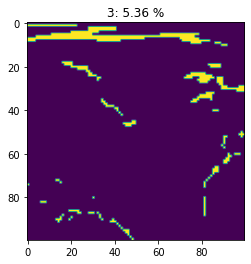

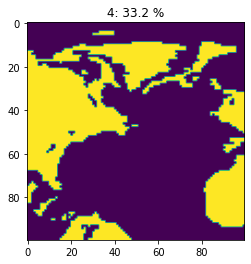

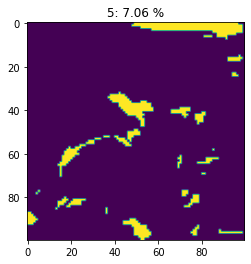

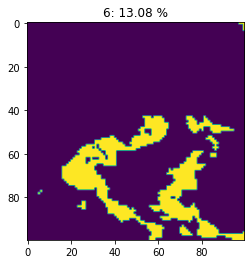

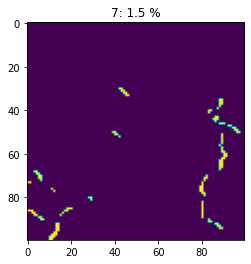

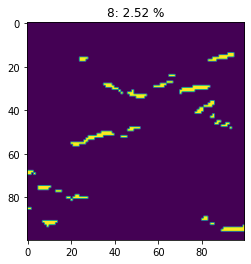

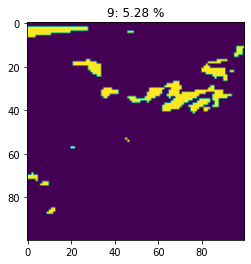

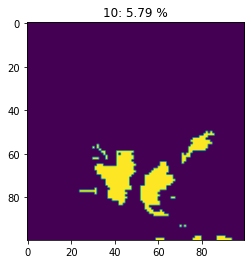

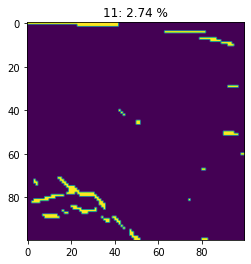

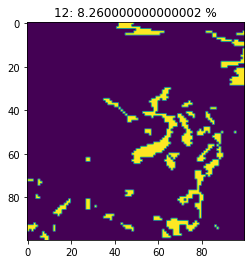

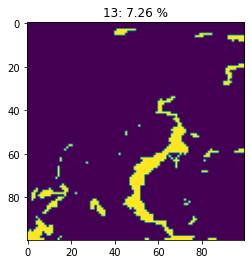

In [101]:
for i in range(1,int(np.max(rslt2))+1):
    plt.figure()
    plt.title(f"{i}: {(rslt2==i).mean() * 100} %")
    plt.imshow(rslt2==i)

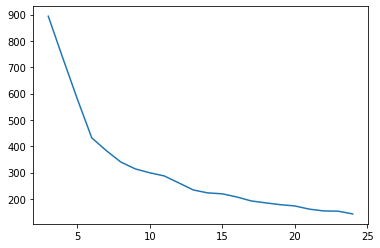

In [209]:
plt.plot([n for n in range(3,25)],inertias)

2851.0308056013487